SciANN-Burgers.ipynb

An illustrain to use SciANN to solve Burgers problem introduced in: https://arxiv.org/pdf/1711.10561.pdf

For additional details, please check our paper at: https://arxiv.org/abs/2005.08803

Created by Ehsan Haghighat on 5/01/20.


In [1]:
# You need to have tensorflow, keras, and sciann installed in your system. 
# On google cloud, uncomment next line to install sciann. 

!pip install sciann 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.1 MB/s 
     |████████████████████████████████| 561 kB 42.9 MB/s 
     |████████████████████████████████| 460.3 MB 7.5 kB/s 
     |████████████████████████████████| 4.0 MB 39.4 MB/s 
     |████████████████████████████████| 462 kB 55.1 MB/s 
     |████████████████████████████████| 1.2 MB 64.4 MB/s 
     |████████████████████████████████| 14.8 MB 39.1 MB/s 
     |████████████████████████████████| 132 kB 46.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68721 sha256=ba11417c8386d6db3ae05a710da4392d46b9f663c44dbb3502fc56724622ce3f
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
   

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import sciann as sn 

---------------------- SCIANN 0.6.6.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0] 



# Burgers problem

The governing equation is: 
$$
  u_{,t} + u u_{,x} - (0.01 / \pi) u_{,xx} = 0, \quad t \in [0, 1], \quad x \in [-1,1]
$$
subjected to 
$$
u(t=0, x) = -\sin(\pi x), \quad u(t, x=\pm 1) = 0
$$

The objective is to solve this equation with PINN. 

## Step 1: Setting up the neural network

The first step is to construct the approximation space. 

The independent variables are: $(t, x)$
The field variable is: $u(t, x)

The neural network approximation is defined as:
$$
\hat{u}: (t, x) \mapsto \mathcal{N}_u(t,x; \mathbf{W}, \mathcal{b})
$$

Here, we use 8 hidden layers with 20 neural units and hyperbolic-tangent activation function. 

In [3]:
x = sn.Variable('x')
t = sn.Variable('t')
u = sn.Functional('u', [t,x], 8*[20], 'tanh')

## Step 2: Setting up the optimzation problem

The second step is to set up the optimization model using SciModel interface. Input variables are $(t, x)$ and targets are:

*   $L_1 : ~~ u_{,t} + u u_{,x} - (0.01 / \pi) u_{,xx}$

In [4]:
from numpy import pi
from sciann.utils.math import diff, sign, sin

In [5]:
L1 = diff(u, t) + u*diff(u,x) - (0.01/pi)*diff(u, x, order=2)

Boundary conditions are: 
*   $C_1: ~~ (1+sign(0 - t))~(u + \sin(\pi x)$
*   $C_2: ~~ (1+sign(-1 - x))~u$
*   $C_3: ~~ (1+sign(x - 1))~u$


In [6]:
TOL = 0.001
C1 = (1-sign(t - TOL)) * (u + sin(pi*x))
C2 = (1-sign(x - (-1+TOL))) * (u)
C3 = (1+sign(x - ( 1-TOL))) * (u)

The "SciModel" with multiple objects is now defined as:

In [7]:
m = sn.SciModel([x, t], [L1, C1, C2, C3])

## Sampling (collocation) grid 

To train the network, we need to define a sampling (collocation) grid.

In [8]:
x_data, t_data = np.meshgrid(
    np.linspace(-1, 1, 100), 
    np.linspace(0, 1, 100)
)

## Training

We can then proform the training: 

In [10]:
h = m.train([x_data, t_data], 4*['zero'], learning_rate=0.002, epochs=1, verbose=0) #recommended epoch: 5000


Total samples: 10000 
Batch size: 64 
Total batches: 157 



## Testing 

There are two ways to evaluate the functionals. 

1- eval without passing the model:
* Not suggested - the data should be provided in the same order as it was defined in the functional: "u = sn.Functional('u', [t,x], 8*[20], 'tanh')"
* u.eval([t_data, x_data])

2- eval with model (suggested): 
* the data should be provided in the same order as it was defined in the SciModel: "m = sn.SciModel([x, t], [L1, C1, C2, C3])"
* u.eval(m, [x_data, t_data]) 

In [11]:
x_test, t_test = np.meshgrid(
    np.linspace(-1, 1, 200), 
    np.linspace(0, 1, 200)
)
u_pred = u.eval(m, [x_test, t_test])

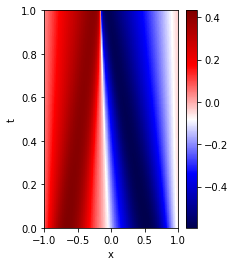

In [12]:
fig = plt.figure(figsize=(3, 4))
plt.pcolor(x_test, t_test, u_pred, cmap='seismic')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()